In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib

df=pd.read_csv('data/Housing.csv')
df.head()

print(df.isnull().sum())

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [3]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df=pd.get_dummies(df,columns=['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea'],drop_first=True)

mapping={"furnished":2,"semi-furnished":1,"unfurnished":0}

df['furnishingstatus']=df['furnishingstatus'].map(mapping)

bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype('int64')

df.head()

,price,area,bedrooms,bathrooms,stories,parking,furnishingstatus,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes
0,13300000,7420,4,2,3,2,2,1,0,0,0,1,1
1,12250000,8960,4,4,4,3,2,1,0,0,0,1,0
2,12250000,9960,3,2,2,2,1,1,0,1,0,0,1
3,12215000,7500,4,2,2,3,2,1,0,1,0,1,1
4,11410000,7420,4,1,2,2,2,1,1,1,0,1,0


In [5]:
df['price_area']=df['price']/df['area']

scaler=MinMaxScaler()
scaled_cols=['area']
df[scaled_cols]=scaler.fit_transform(df[scaled_cols])
df.head()

,price,area,bedrooms,bathrooms,stories,parking,furnishingstatus,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,price_area
0,13300000,0.396564,4,2,3,2,2,1,0,0,0,1,1,1792.452830
1,12250000,0.502405,4,4,4,3,2,1,0,0,0,1,0,1367.187500
2,12250000,0.571134,3,2,2,2,1,1,0,1,0,0,1,1229.919679
3,12215000,0.402062,4,2,2,3,2,1,0,1,0,1,1,1628.666667
4,11410000,0.396564,4,1,2,2,2,1,1,1,0,1,0,1537.735849


In [6]:
df['area_bedrooms'] = df['area'] * df['bedrooms']
df['stories_bathrooms'] = df['stories'] * df['bathrooms']


df['luxury_index'] = (df['airconditioning_yes'] + df['hotwaterheating_yes'] + df['guestroom_yes'] + df['basement_yes'])

amenity_cols = [
    'mainroad_yes', 'guestroom_yes', 'basement_yes',
    'hotwaterheating_yes', 'airconditioning_yes', 'prefarea_yes'
]

df['amenities_count'] = df[amenity_cols].sum(axis=1)

In [7]:
def outlier_removal(df, column, threshold=1.5):
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1-threshold*IQR
    upper=Q3+threshold*IQR
    filtered=df[(df[column]>=lower) & (df[column]<=upper)]
    return filtered

df=outlier_removal(df,'price')

In [8]:
from sklearn.model_selection import train_test_split

X=df.drop(['price','price_area'],axis=1)
y=df['price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [9]:
from xgboost import XGBRegressor
model=XGBRegressor(n_estimators=800,learning_rate=0.05,max_depth=6,subsample=0.8,colsample_bytree=0.8,random_state=42).fit(X_train, y_train)
pred=model.predict(X_test)
print(mean_squared_error(y_test,pred))
print(r2_score(y_test,pred))


1203522109440.0
0.623033344745636


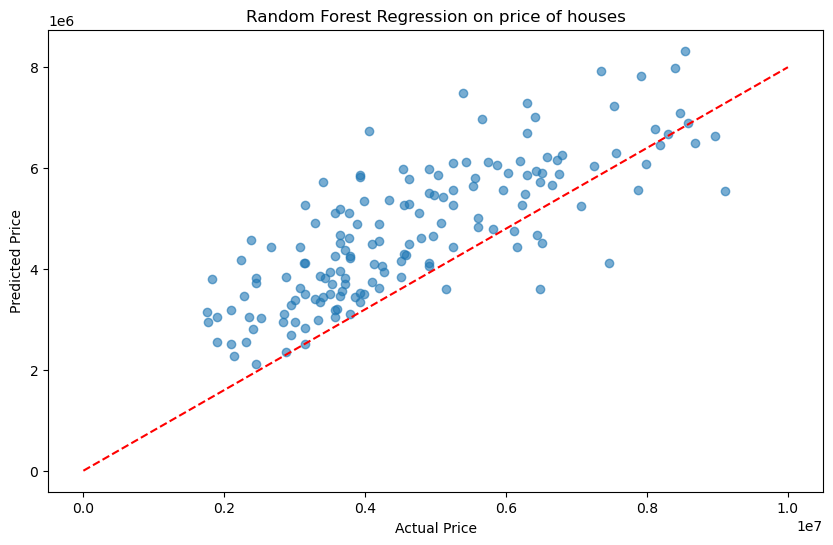

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(y_test,pred,alpha=0.6)
plt.title("Random Forest Regression on price of houses")
plt.plot([0,10*1e6],[0,8*1e6],'r--',label="Perfect Prediction",lw=1.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

In [11]:
joblib.dump(model,"model.pkl")
joblib.dump(scaler,"scaler.pkl")
print("Mode and Scaler saved as model.pkl and scaler.pkl respectively")

Mode and Scaler saved as model.pkl and scaler.pkl respectively
